# 📦 Visual AI with Gemini: Detection, Captioning, Reasoning, OCR

Object detection is a fundamental task in computer vision, used to identify and localize objects, features, or areas of interest within images. With the rise of multimodal large models like Google’s **Gemini**, these tasks can now be performed using natural language prompts—eliminating the need for traditional training workflows or extensive annotated datasets.

This project showcases how to utilize **Gemini 2.0 Flash** and **Gemini 2.5 Pro** for visual understanding through three key capabilities:



### 🔍 1. Detection

Gemini can detect and generate 2D bounding boxes around important regions in an image. This includes objects, anomalies, landmarks, or any user-defined features. The process is fully guided by natural language and requires no model fine-tuning or prior training data.



### 🧠 2. Visual Reasoning

Beyond detection, Gemini is capable of interpreting visual content in context. This includes distinguishing between similar visual patterns, analyzing spatial relationships, understanding scene complexity, and drawing logical conclusions—similar to how a human might interpret an image.



### 🖋️ 3. Visual Captioning

Gemini can generate rich, descriptive captions for images, capturing elements like shape, color, texture, structure, and context. These captions improve transparency and can support a wide range of applications including content summarization, accessibility, documentation, and automation.

<br>

### 🧩 Summary

| Component            | Task Type               | Description                                                  |
|----------------------|--------------------------|--------------------------------------------------------------|
| **Detection**        | Bounding Box Localization| Identifies and highlights key areas within images            |
| **Reasoning**        | Visual Interpretation     | Understands and interprets complex visual information        |
| **Captioning**       | Natural Language Summary  | Produces descriptive summaries of visual content             |
<br>


### 🔍 About the Models

- **[Gemini 2.0 Flash](https://ai.google.dev/gemini-api/docs/models/gemini#gemini-2.0-flash)**: Optimized for fast, lightweight inference—ideal for interactive tasks with lower latency.
- **[Gemini 2.5 Pro](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro-exp-03-25)**: A more powerful version, capable of handling complex multimodal prompts and providing higher-quality results for detailed object recognition.


## 🚀 Get Started with Gemini

Before diving into object detection with Gemini, you'll need to set up your environment. Follow the steps below to get started quickly:

### 🔑 Get Your Free API Key

To use Gemini models, you need an API key from **Google AI Studio**:

1. Visit [Google AI Studio](https://aistudio.google.com/app/apikey).
2. Sign in with your Google account.
3. Click on **"Create API Key"** and copy the generated key.

In [1]:
%pip install -U -q google-genai
# already installed in Colab, but for local env: pip install Pillow

In [2]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [3]:
from google import genai

client = genai.Client(api_key=GOOGLE_API_KEY)

Load test dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!gdown --id 1Mafi6V95rRUaVN49WVXfJo5aouwYRagf

!unzip ./object_dataset.zip
!rm -f ./object_dataset.zip

Mounted at /content/drive
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Mafi6V95rRUaVN49WVXfJo5aouwYRagf
To: /content/object_dataset.zip
100% 4.13M/4.13M [00:00<00:00, 167MB/s]
Archive:  ./object_dataset.zip
  inflating: object_dataset/image (1).jpeg  
  inflating: object_dataset/image (1).jpg  
  inflating: object_dataset/image (1).png  
  inflating: object_dataset/image (10).jpeg  
  inflating: object_dataset/image (11).jpeg  
  inflating: object_dataset/image (12).jpeg  
  inflating: object_dataset/image (13).jpeg  
  inflating: object_dataset/image (14).jpeg  
  inflating: object_dataset/image (4).jpg  
  inflating: object_dataset/image (5).jpg  
  inflating: object_dataset/image (7).jpeg  
  inflating: object_dataset/image (8).jpeg  
  inflating: object_dat


### 📷 Loading an Image

**From a URL:**
```python
from PIL import Image
import requests
from io import BytesIO

url = 'https://www.shutterstock.com/image-photo/problem-acne'
image = Image.open(BytesIO(requests.get(url).content))
```

**From a Local File:**
```python
from PIL import Image

image_path = '/content/test_dataset/alopecia.jpg'
image = Image.open(image_path)
```

# **Detection**

This is an **🔍 object detection task** because the prompt:

> `"Detect and draw 2D bounding boxes around objects in the image"`

is asking the model to:
- 🧠 **Find** objects in the image (**detection**)
- 📦 **Draw** boxes to show where they are (**localization**)

We're not generating 📝 descriptions (captioning) or assigning 🏷️ labels (classification)—just marking locations. That’s classic **object detection**!

In [5]:
import requests
from io import BytesIO
from PIL import Image   # for local envs, install Pillow with `pip install Pillow`
from pydantic import BaseModel
from PIL import Image, ImageDraw, ImageFont

Detected bounding boxes: [BoundingBox(box_2d=[526, 626, 888, 922], label='Armchair'), BoundingBox(box_2d=[257, 295, 488, 435], label='Painting'), BoundingBox(box_2d=[660, 489, 874, 638], label='Footstool'), BoundingBox(box_2d=[492, 528, 636, 761], label='Television stand'), BoundingBox(box_2d=[317, 758, 642, 952], label='Cabinet'), BoundingBox(box_2d=[534, 45, 920, 396], label='Loveseat'), BoundingBox(box_2d=[233, 444, 592, 550], label='Cabinet'), BoundingBox(box_2d=[795, 242, 1000, 997], label='Rug'), BoundingBox(box_2d=[392, 583, 519, 710], label='Television'), BoundingBox(box_2d=[430, 80, 654, 393], label='Sofa bed'), BoundingBox(box_2d=[300, 357, 556, 469], label='Houseplant'), BoundingBox(box_2d=[244, 550, 358, 759], label='Shelf'), BoundingBox(box_2d=[574, 310, 786, 529], label='Coffee table')]


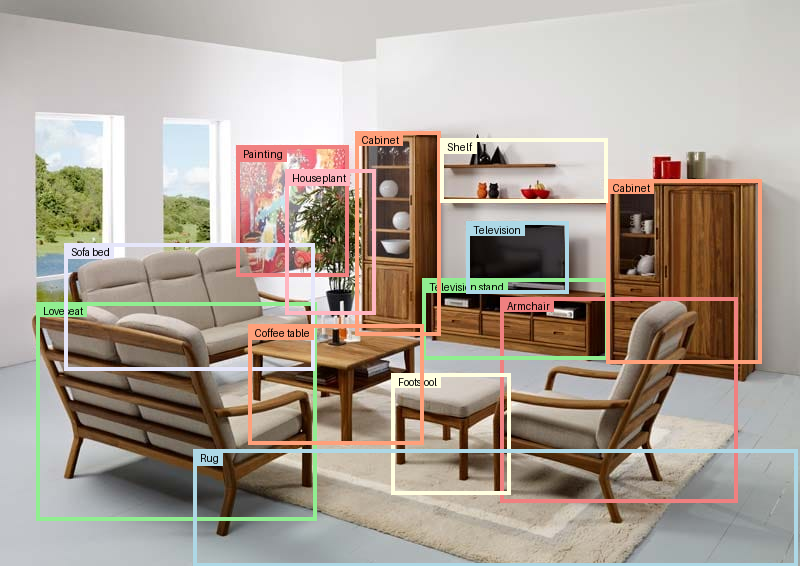

In [8]:
def process_image_with_prompt(prompt: str, image: Image.Image):
    """
    Uses the Gemini model to detect related class bounding boxes in an image,
    then draws and displays these boxes with labels.

    Parameters:
        prompt (str): The detection prompt to be sent to the model.
        image (PIL.Image): The input image to process.
    """
    # Define the schema for bounding boxes.
    class BoundingBox(BaseModel):
        box_2d: list[int]  # Coordinates in normalized form (assumed range [0, 1000])
        label: str         # Detected label

    # Generate bounding boxes using the Gemini model.
    response = client.models.generate_content(
        model="gemini-2.5-pro-exp-03-25",  # Alternatively, use "gemini-2.0-flash"
        contents=[prompt, image],
        config={
            'response_mime_type': 'application/json',
            'response_schema': list[BoundingBox],
        },
    )
    bounding_boxes = response.parsed
    print("Detected bounding boxes:", bounding_boxes)

    # Set drawing parameters.
    line_width = 4
    font = ImageFont.load_default()

    # Extract unique labels to assign consistent colors.
    labels = list(set(box.label for box in bounding_boxes))
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lightsalmon', 'lightpink', 'lavender']

    # Create a copy of the image and get dimensions.
    img = image.copy()
    width, height = img.size
    draw = ImageDraw.Draw(img)

    # Iterate over each bounding box.
    for box in bounding_boxes:
        # Unpack normalized coordinates.
        y_min, x_min, y_max, x_max = box.box_2d

        # Convert normalized coordinates to absolute pixel values.
        y_min = int(y_min / 1000 * height)
        x_min = int(x_min / 1000 * width)
        y_max = int(y_max / 1000 * height)
        x_max = int(x_max / 1000 * width)

        # Choose a color based on the label.
        color = colors[labels.index(box.label) % len(colors)]

        # Draw the bounding rectangle.
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=color, width=line_width)

        # Prepare the text.
        text = box.label
        # Measure text size using draw.textbbox (works in place of font.getsize)
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        # Define padding for the background rectangle.
        padding = 3

        # Define coordinates for the background rectangle.
        bg_x0 = x_min + line_width
        bg_y0 = y_min
        bg_x1 = bg_x0 + text_width + 2 * padding
        bg_y1 = bg_y0 + text_height + 2 * padding

        # Draw the background rectangle (highlight) in a contrasting color.
        draw.rectangle([(bg_x0, bg_y0), (bg_x1, bg_y1)], fill=color)
        # Draw the text over the rectangle with black color.
        draw.text((bg_x0 + padding, bg_y0 + padding), text, fill="black", font=font)

    # Display the image with bounding boxes.
    display(img)

image_path = '/content/object_dataset/image (1).jpeg'
image = Image.open(image_path)

prompt = """Detect and draw 2D bounding boxes around objects in the image"""

process_image_with_prompt(prompt, image)

Detected bounding boxes: [BoundingBox(box_2d=[246, 71, 648, 431], label='Truck'), BoundingBox(box_2d=[176, 451, 383, 610], label='Truck'), BoundingBox(box_2d=[316, 629, 626, 810], label='Bus'), BoundingBox(box_2d=[740, 0, 997, 117], label='Car'), BoundingBox(box_2d=[883, 18, 1000, 234], label='Car'), BoundingBox(box_2d=[444, 339, 595, 475], label='Car'), BoundingBox(box_2d=[621, 346, 800, 518], label='Car'), BoundingBox(box_2d=[413, 446, 504, 534], label='Car'), BoundingBox(box_2d=[476, 479, 604, 592], label='Car'), BoundingBox(box_2d=[310, 584, 379, 650], label='Car'), BoundingBox(box_2d=[265, 732, 316, 785], label='Car'), BoundingBox(box_2d=[219, 704, 265, 750], label='Car'), BoundingBox(box_2d=[214, 779, 262, 818], label='Car'), BoundingBox(box_2d=[179, 800, 214, 840], label='Car'), BoundingBox(box_2d=[242, 606, 290, 650], label='Car'), BoundingBox(box_2d=[191, 679, 231, 714], label='Car'), BoundingBox(box_2d=[159, 726, 194, 754], label='Car'), BoundingBox(box_2d=[191, 748, 225, 781

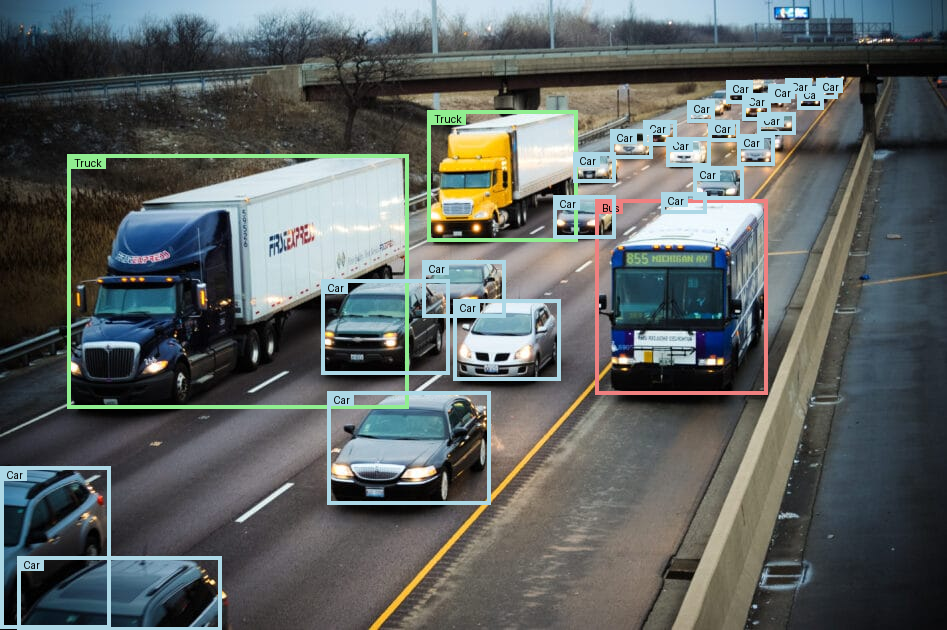

In [9]:
image_path = '/content/object_dataset/image (9).jpeg'
image = Image.open(image_path)

prompt = """Detect and draw 2D bounding boxes around objects in the image"""

process_image_with_prompt(prompt, image)

# **Image Reasoning**


### 🧠 Example 1:
> `"Detect the 2D bounding boxes of all visible persons holding a cup in the image."`

This requires:
- Detecting **persons** 👤
- Then checking if they’re **holding a cup** ☕
- The model must **understand relationships** and actions — not just objects.

✅ **That’s visual reasoning** — it combines detection *and* interpretation of actions/contexts.


### 🧠 Example 2:
> `"Detect the 2D bounding boxes of all visible bell peppers and cauliflowers in the image."`

Even though it's a bit simpler, it still needs:
- Identifying **specific object types** (not just “vegetables” in general)
- Differentiating similar-looking objects (like bell peppers 🫑 vs. cauliflowers 🥦)
- This shows **fine-grained reasoning** and **object differentiation**


### 📌 Summary:

These prompts require the model to:
- 🧠 **Interpret object relationships or actions** (e.g., “holding a cup”)
- 🎯 **Distinguish similar objects** with subtle differences

That goes beyond basic detection — it's **visual reasoning** in action.

<br>

Detected bounding boxes: [BoundingBox(box_2d=[0, 648, 166, 861], label='bell pepper'), BoundingBox(box_2d=[94, 692, 298, 929], label='bell pepper'), BoundingBox(box_2d=[615, 161, 698, 240], label='cauliflower'), BoundingBox(box_2d=[683, 242, 771, 329], label='cauliflower'), BoundingBox(box_2d=[610, 240, 690, 324], label='cauliflower'), BoundingBox(box_2d=[342, 674, 546, 897], label='bell pepper'), BoundingBox(box_2d=[344, 861, 542, 1000], label='bell pepper'), BoundingBox(box_2d=[635, 318, 738, 388], label='cauliflower'), BoundingBox(box_2d=[573, 235, 619, 312], label='cauliflower'), BoundingBox(box_2d=[688, 163, 779, 248], label='cauliflower'), BoundingBox(box_2d=[102, 874, 294, 1000], label='bell pepper'), BoundingBox(box_2d=[585, 342, 654, 407], label='cauliflower')]


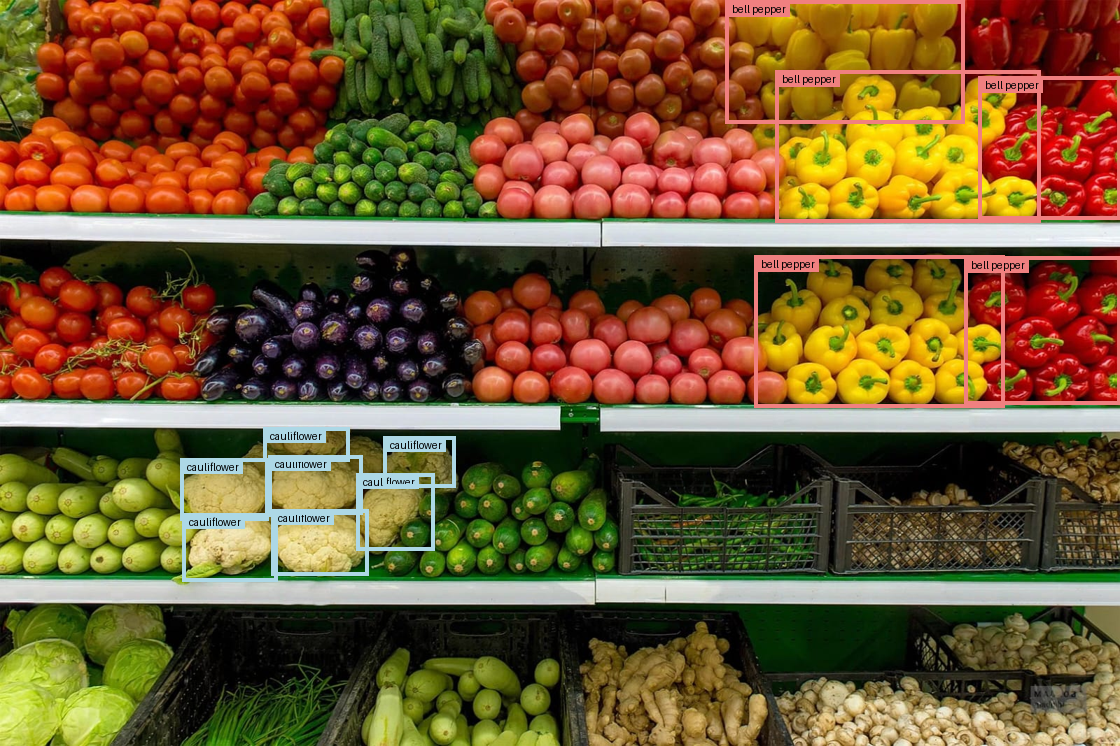

In [10]:
from PIL import Image

# Load image
image_path = '/content/object_dataset/image (10).jpeg'
image = Image.open(image_path)

# Use the resized image with your prompt
prompt = """Detect the 2D bounding boxes of all visible bell peppers and cauliflowers in the image."""
process_image_with_prompt(prompt, image)


Detected bounding boxes: [BoundingBox(box_2d=[188, 665, 927, 828], label='person holding a cup'), BoundingBox(box_2d=[240, 846, 1000, 1000], label='person holding a cup')]


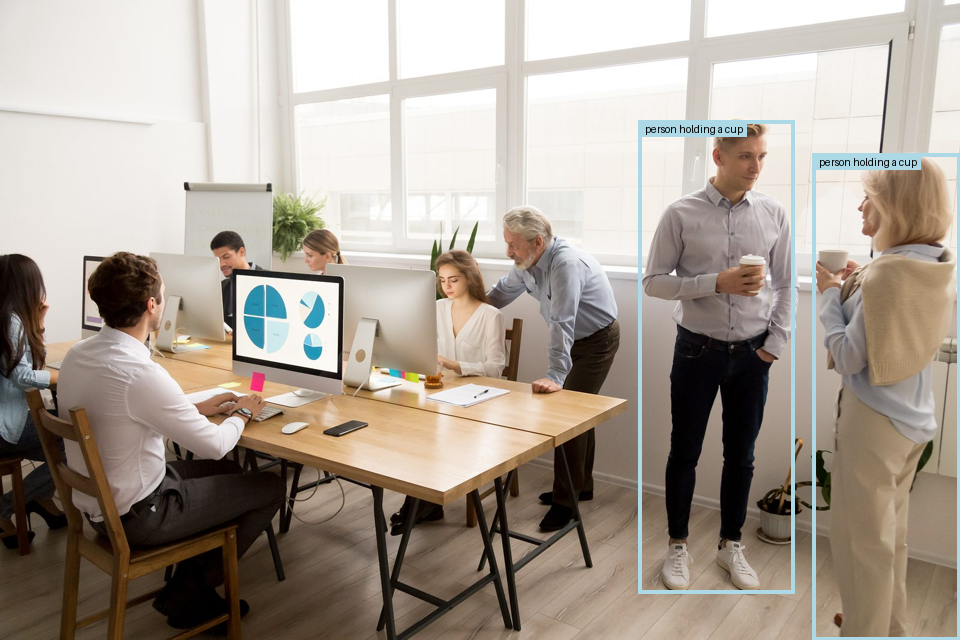

In [11]:
image_path = '/content/object_dataset/image (5).jpg'
image = Image.open(image_path)

prompt = """Detect the 2D bounding boxes of all visible persons holding a cup in the image."""

process_image_with_prompt(prompt, image)

# **Image Captioning**

Let’s look at the **caption prompt**:

> `"Provide a detailed explanation about the image."`

This asks the model to:
- 📝 **Describe** what it sees in the image
- 🧠 Include details like objects, scene context, actions, colors, layout, etc.
- 🗣️ Output **textual information**, not boxes or labels

This is exactly what **image captioning** does:  
✅ Turn visual information → natural language description

We’re not marking objects—you’re asking the model to **explain the image in words**, which makes it **image captioning**.

In [18]:
from PIL import Image, ImageDraw, ImageFont
from pydantic import BaseModel

def process_image_with_prompt(prompt: str, image: Image.Image):
    """
    Uses the Gemini model to detect related class bounding boxes in an image,
    then draws and displays these boxes with labels highlighted against a contrasting background.

    Parameters:
        prompt (str): The detection prompt to be sent to the model.
        image (PIL.Image): The input image to process.
    """
    # Define the schema for bounding boxes.
    class BoundingBox(BaseModel):
        box_2d: list[int]  # Coordinates in normalized form (assumed range [0, 1000])
        label: str         # Detected label (e.g., "suspicious" or "normal")

    # Generate bounding boxes using the Gemini model.
    response = client.models.generate_content(
        model="gemini-2.5-pro-exp-03-25",  # Alternatively, use "gemini-2.0-flash"
        contents=[prompt, image],
        config={
            'response_mime_type': 'application/json',
            'response_schema': list[BoundingBox],
        },
    )
    bounding_boxes = response.parsed
    print("Detected bounding boxes:", bounding_boxes)

    # Set drawing parameters.
    line_width = 4
    font = ImageFont.load_default()

    # Extract unique labels to assign consistent colors.
    labels = list(set(box.label for box in bounding_boxes))
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lightsalmon', 'lightpink', 'lavender']

    # Create a copy of the image and get dimensions.
    img = image.copy()
    width, height = img.size
    draw = ImageDraw.Draw(img)

    # Iterate over each bounding box.
    for box in bounding_boxes:
        # Unpack normalized coordinates.
        y_min, x_min, y_max, x_max = box.box_2d

        # Convert normalized coordinates to absolute pixel values.
        y_min = int(y_min / 1000 * height)
        x_min = int(x_min / 1000 * width)
        y_max = int(y_max / 1000 * height)
        x_max = int(x_max / 1000 * width)

        # Choose a color based on the label.
        color = colors[labels.index(box.label) % len(colors)]

        # Draw the bounding rectangle.
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=color, width=line_width)

        # Prepare the text.
        text = box.label
        # Measure text size using draw.textbbox (available in recent Pillow versions)
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        padding = 3

        # Define coordinates for the background rectangle for text highlight.
        bg_x0 = x_min + line_width
        bg_y0 = y_min
        bg_x1 = bg_x0 + text_width + 2 * padding
        bg_y1 = bg_y0 + text_height + 2 * padding

        # Draw the background rectangle (highlight) with a contrasting color.
        draw.rectangle([(bg_x0, bg_y0), (bg_x1, bg_y1)], fill=color)
        # Draw the label text over the background with black color.
        draw.text((bg_x0 + padding, bg_y0 + padding), text, fill="black", font=font)

    # Display the image with bounding boxes.
    display(img)

def generate_image_caption(image: Image.Image, caption_prompt: str) -> str:
    """
    Uses the Gemini model to generate an explanatory caption for the image.
    The caption summarizes key visual features, including any suspicious regions.

    Parameters:
        image (PIL.Image): The input image to caption.
        caption_prompt (str): The caption prompt to be sent to the model.

    Returns:
        str: The generated caption.
    """
    response = client.models.generate_content(
        model="gemini-2.5-pro-exp-03-25",  # Use the appropriate model for captioning.
        contents=[caption_prompt, image],
        config={'response_mime_type': 'text/plain'},
    )
    caption = response.text
    return caption


Detected bounding boxes: [BoundingBox(box_2d=[88, 421, 402, 600], label='Cricket Bat'), BoundingBox(box_2d=[600, 396, 938, 457], label='Cricket Wicket'), BoundingBox(box_2d=[312, 75, 940, 391], label='Cricket Player'), BoundingBox(box_2d=[660, 115, 900, 244], label='Cricket Pad'), BoundingBox(box_2d=[308, 536, 412, 615], label='Cricket Glove'), BoundingBox(box_2d=[620, 650, 908, 753], label='Cricket Pad'), BoundingBox(box_2d=[518, 291, 618, 391], label='Cricket Glove'), BoundingBox(box_2d=[635, 274, 670, 305], label='Cricket Ball'), BoundingBox(box_2d=[230, 659, 365, 764], label='Cricket Helmet'), BoundingBox(box_2d=[230, 529, 938, 800], label='Cricket Player'), BoundingBox(box_2d=[310, 261, 450, 363], label='Cricket Helmet'), BoundingBox(box_2d=[640, 261, 890, 325], label='Cricket Pad')]


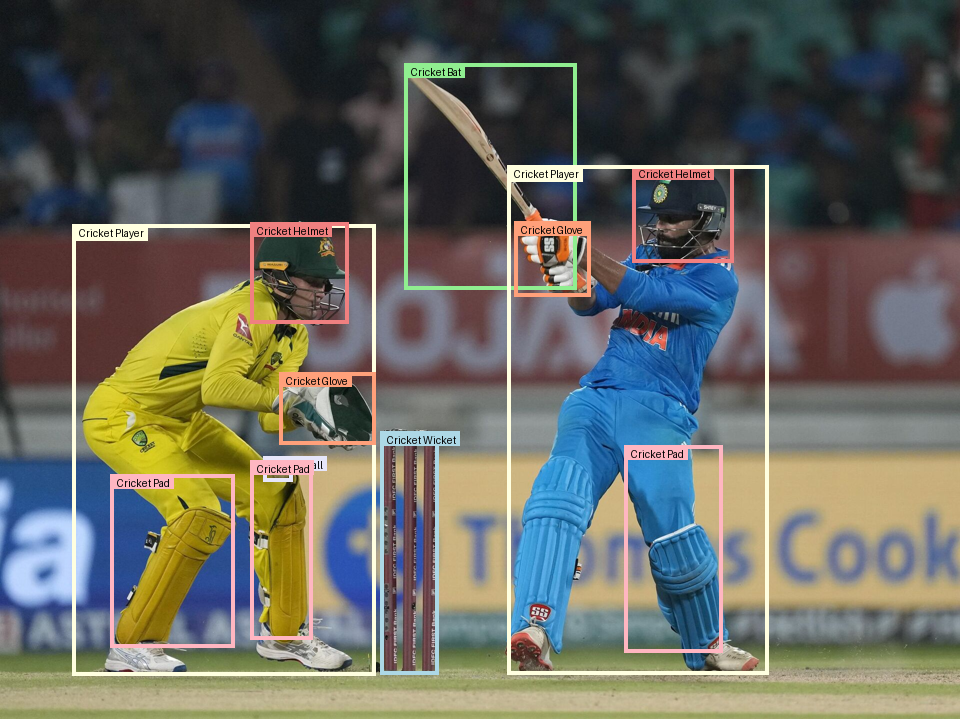

Image Caption: Based on the image provided, here's a detailed explanation:

1.  **Context:** The image captures a moment during a professional cricket match.
2.  **Teams Involved:** The match is being played between the Indian cricket team (batsman in blue) and the Australian cricket team (wicketkeeper in yellow/gold). The team colors indicate this is likely a limited-overs match, either a One Day International (ODI) or a T20 International (T20I).
3.  **Action:**
    *   **Batsman:** The Indian batsman (who appears to be left-handed, potentially Ravindra Jadeja based on appearance and stance) is in the process of executing a shot. His bat is raised high in the follow-through, suggesting a powerful stroke, possibly aimed towards the leg side (his right side). He is wearing full protective gear: helmet with the Indian flag emblem, batting gloves, chest guard (under the jersey), thigh pad, and leg pads.
    *   **Wicketkeeper:** The Australian wicketkeeper is in a low, athletic crouch beh

In [25]:
image_path = '/content/object_dataset/image (1).jpg'

image = Image.open(image_path)

# Detection prompt for bounding box generation.
detection_prompt = """Detect and draw 2D bounding boxes around cricket sport objects in the image"""
process_image_with_prompt(detection_prompt, image)

# Caption prompt passed as input.
caption_prompt = "Provide a detailed explanation about the image."

caption = generate_image_caption(image, caption_prompt)
print("Image Caption:", caption)

# **Text Extraction / OCR**

Let’s look at the **caption prompt**:

> `"Extract the text from the number plate."`

This tells the model to:
- 👀 **Find the number plate** in the image
- 🔍 **Read and recognize the characters** on it
- 🧾 Return the **actual text** it sees

This process is known as **OCR (Optical Character Recognition)** — converting **visual text** in images to **actual machine-readable text**.

We're not just describing or detecting — you're asking the model to **read** what's written. That’s classic **OCR**. ✅

Detected bounding boxes: [BoundingBox(box_2d=[534, 401, 589, 634], label='number plate')]


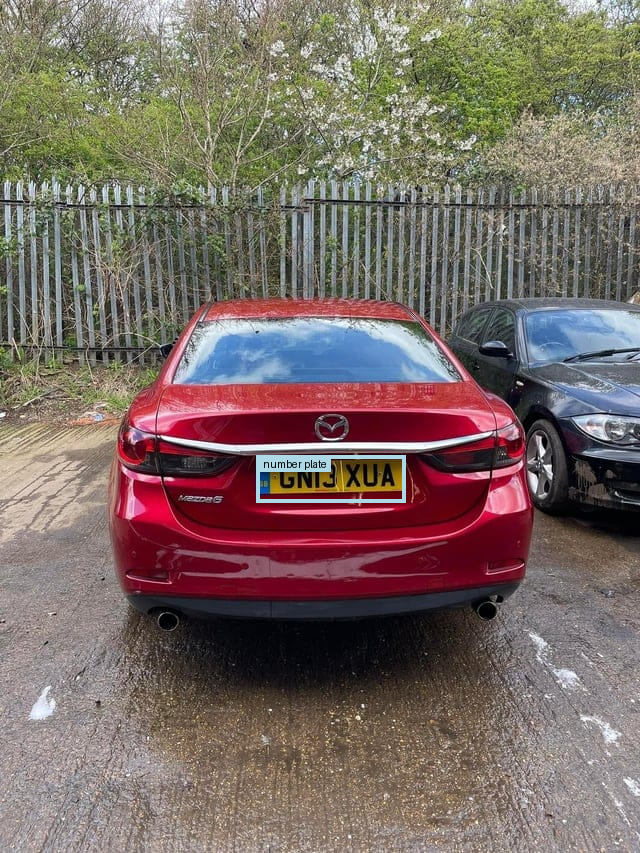

Extracted text: GN13 XUA


In [21]:
image_path = '/content/object_dataset/image (13).jpeg'

image = Image.open(image_path)

# Detection prompt for bounding box generation.
detection_prompt = """Detect and draw 2D bounding boxe around the number plate"""
process_image_with_prompt(detection_prompt, image)

# Caption prompt passed as input.
caption_prompt = "Extract the text from the number plate."

caption = generate_image_caption(image, caption_prompt)
print("Extracted text:", caption)